# Модель ResNet 18 с датасетом EMNIST

In [1]:
! pip install torch-summary -q

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary

In [3]:
def evaluate_accuracy(data_iter, net):
    '''
    Функция подсчета метрики accuracy,
    '''
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [197]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 50 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка данных

In [182]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [183]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [184]:
# dataiter = iter(train_iter)

In [185]:
dataiter = iter(train_dataset)

In [186]:
classes = train_dataset.classes

Размер изображения torch.Size([224, 224])
r


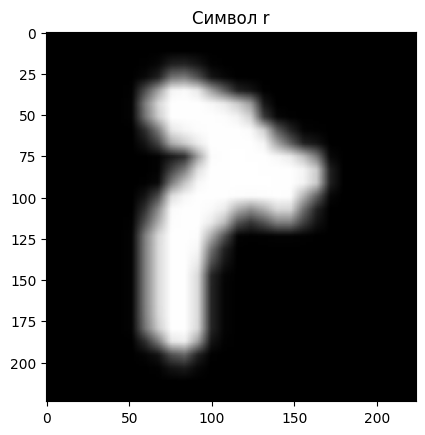

In [187]:
data = next(dataiter)
features, labels = data
print('Размер изображения', features[0].shape)
label = classes[labels]
print(label)
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
# plt.title('Класс '+ str(labels[0].item()))
plt.title('Символ ' + str(label))
plt.show()

In [188]:
dataiter = iter(train_iter)
data = next(dataiter)
features, labels = data
print('Количество классов:', len(torch.unique(labels)))
print('Классы:', torch.unique(labels))
print('Индексы и классы:', train_dataset.class_to_idx)
print('Классы', train_dataset.classes)

Количество классов: 47
Классы: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])
Индексы и классы: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'n': 43, 'q': 44, 'r': 45, 't': 46}
Классы ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [189]:
model = tv.models.resnet18(pretrained=True)

In [190]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [191]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [192]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [193]:
# меняем последний слой
model.fc = nn.Linear(in_features=512, out_features=47)

In [194]:
# Собираем параметры для обучения
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [195]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [198]:
train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 0.713. Train acc: 0.777. Train Loss: 0.845
Step 50. time since epoch: 35.963. Train acc: 0.761. Train Loss: 0.874
Step 100. time since epoch: 71.925. Train acc: 0.765. Train Loss: 0.862
Step 150. time since epoch: 107.850. Train acc: 0.768. Train Loss: 0.846
Step 200. time since epoch: 143.559. Train acc: 0.770. Train Loss: 0.830
Step 250. time since epoch: 178.851. Train acc: 0.772. Train Loss: 0.822
Step 300. time since epoch: 213.949. Train acc: 0.773. Train Loss: 0.811
Step 350. time since epoch: 249.249. Train acc: 0.774. Train Loss: 0.801
Step 400. time since epoch: 283.392. Train acc: 0.775. Train Loss: 0.794
--------------------
epoch 1, loss 0.7891, train acc 0.775, test acc 0.780, time 350.1 sec
Step 0. time since epoch: 0.634. Train acc: 0.793. Train Loss: 0.698
Step 50. time since epoch: 36.023. Train acc: 0.789. Train Loss: 0.722
Step 100. time since epoch: 70.896. Train acc: 0.791. Train Loss: 0.716
Step 150. time since epoch: 103.985. Train acc:

In [225]:
data = {
    'Модель': ['ResNet18', 'ResNet18', 'ResNet18'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.780, 0.79, 0.798],
    'Test_loss': [0.7891, 0.6813, 0.6304]
}
res = pd.DataFrame(data)
print(res)

     Модель  Номер эпохи  Test_acc  Test_loss
0  ResNet18            1     0.780     0.7891
1  ResNet18            2     0.790     0.6813
2  ResNet18            3     0.798     0.6304


In [226]:
# res.loc[len(res)] = ['ResNet18', '1', '0.780', '0.7891']
# res